In [1]:
%%html
<style type='text/css'>
.CodeMirror{
font-family: JetBrains Mono;
</style>

In [2]:
# Suggested imports. Do not use import any modules that are not in the requirements.txt file on the VLE.

import sklearn.metrics
import sklearn.model_selection
import matplotlib.pyplot as plt
import random
import collections
import torch
import pandas as pd
import numpy as np
%matplotlib inline


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

# Movie titles assignment

Table of contents:

* [Data filtering and splitting (10%)](#Data-filtering-and-splitting-(10%))
* [Title classification (25%)](#Title-classification-(25%))
* [Title generation (25%)](#Title-generation-(25%))
* [Language models as classifiers (30%)](#Language-models-as-classifiers-(30%))
* [Conclusion (10%)](#Conclusion-(10%))

Information:

This assignment is 100% of your assessment.
You are to follow the instructions below and fill each cell as instructed.
Once ready, submit this notebook on VLE with all the outputs included (run all your code and don't clear any output cells).
Do not submit anything else apart from the notebook and do not use any extra data apart from what is requested.

## Introduction

A big shot Hollywood producer is looking for a way to automatically generate new movie titles for future movies and you have been employed to do this (in exchange for millions of dollars!).
A data set of movie details has already been collected from IMDb for you and your task is to create the model and the algorithms necessary to use it.

## Data filtering and splitting (10%)

Start by downloading the CSV file `filmtv_movies - ENG.csv` from [this kaggle data set](https://www.kaggle.com/datasets/stefanoleone992/filmtv-movies-dataset).

The CSV file needs to be filtered as the producer is only interested in certain types of movie titles.
Load the file and filter it so that only movies with the following criteria are kept:

* The country needs to be `United States` (and no other country should be mentioned).
* The genre should be `Action`, `Horror`, `Fantasy`, `Western`, and `Adventure`.
* The title should not have more than 20 characters.

In [3]:
df = pd.read_csv('data.csv')  #Load full csv
df = df[df['country'] == 'United States'] #Country == United States
df = df[df['genre'].isin(['Action','Horror','Fantasy','Western','Adventure'])] #Filter genre
df = df[df['title'].str.len() < 21] # Title does not have more than 20 characters
df['title'] = df['title'].apply(lambda s: s.lower()) #Set all titles to lowercase
df = df[['title','genre']] # Only title and genre columns are needed


df = df.sample(frac=1) #Shuffle dataset
df.to_csv('filtered_data.csv', index=False)
df

,title,genre
3755,tales of terror,Horror
15320,princess of thieves,Adventure
30987,the gallows,Horror
25192,hydra,Fantasy
17806,war of the worlds,Fantasy
...,...,...
3682,forty guns,Western
29596,midnight chronicles,Action
30228,insidious: chapter 3,Horror
3435,little big man,Western


Split the filtered data into 80% train, 10% validation, and 10% test.
You will only need the title and genre columns.

In [4]:
#df = pd.read_csv('filtered_data.csv')

#Train = 80%, Other = 20%
train_x, other_x, train_y, other_y = sklearn.model_selection.train_test_split(df['title'],df['genre'],
                                                             test_size=0.2, random_state=1)


#Split other in half -> [Train = 80%, Val = 10%, Test = 10%]
val_x, test_x, val_y, test_y = sklearn.model_selection.train_test_split(other_x, other_y,
                                                       test_size=0.5, random_state=1)



From your processed data set, display:

* the amount of movies in each genre and split
* 5 examples of movie titles from each genre and split

In [5]:
print('Amount of Movies in Training Set:')
print(train_y.value_counts())

print('\nAmount of Movies in Validation Set:')
print(val_y.value_counts())

print('\nAmount of Movies in Testing Set:')
print(test_y.value_counts())

Amount of Movies in Training Set:
Action       705
Horror       672
Fantasy      438
Western      409
Adventure    375
Name: genre, dtype: int64

Amount of Movies in Validation Set:
Action       86
Horror       73
Western      70
Fantasy      59
Adventure    37
Name: genre, dtype: int64

Amount of Movies in Testing Set:
Action       97
Horror       73
Western      58
Adventure    52
Fantasy      45
Name: genre, dtype: int64


In [6]:
train = pd.DataFrame(columns=['title'], data=train_x)
train['genre'] = train_y

val = pd.DataFrame(columns=['title'], data=val_x)
val['genre'] = val_y

test = pd.DataFrame(columns=['title'], data=test_x)
test['genre'] = test_y

for genre in ['Action','Horror','Fantasy','Western','Adventure']:  
    print(f'5 Random {genre} movies from each split:')
    
    print(f"Train:{list(train[train['genre']==genre]['title'].sample(n=5).apply(lambda s: ''.join(s)))}\n")
    print(f"Validate:{list(val[val['genre']==genre]['title'].sample(n=5).apply(lambda s: ''.join(s)))}\n")    
    print(f"Test:{list(test[test['genre']==genre]['title'].sample(n=5).apply(lambda s: ''.join(s)))}\n")
    
    print('\n\n=================================\n')
    

5 Random Action movies from each split:
Train:["assassin's bullet", 'vfw', 'wanted', 'urgency', 'masterminds']

Validate:['deep impact', 'the lone ranger', 'reprisal', 'maximum risk', 'quick change']

Test:['mongolian death worm', 'mega piranha', 'ink', 'final descent', 'top of the world']




5 Random Horror movies from each split:
Train:['the exorcist iii', 'the quiet ones', 'insidious: chapter 3', '13 sins', 'devil']

Validate:['gacy', 'hostel: part ii', 'empire of the ants', 'disturbing behaviour', 'it']

Test:['dead season', "satan's cheerleaders", 'the green inferno', 'prime evil', 'rattlesnake']




5 Random Fantasy movies from each split:
Train:['conan the destroyer', 'bicentennial man', 'fantastic voyage', '40 days and nights', 'the final countdown']

Validate:['dna', 'innerspace', 'time cop', 'legion', 'eve of destruction']

Test:['air', 'mars attacks!', 'prometheus', 'sabrina, down under', 'i am legend']




5 Random Western movies from each split:
Train:['red sundown', 'kan

## Title classification (25%)

Your first task is to prove that a neural network can identify the genre of a movie based on its title.

You will note that many titles are just a single word or two words long so you need to work at the character level instead of the word level, that is, a token would be a single character, including punctuation marks and spaces.
You must also lowercase the titles.
Preprocess the data sets, create a neural network, and train it to classify the movie titles into their genre.
Plot a graph of the **accuracy** of the model on the train and validation sets after each epoch.

In [5]:
# Tokenise each character.
train_x = train_x.apply(lambda s: [*s])
val_x = val_x.apply(lambda s: [*s])
test_x = test_x.apply(lambda s: [*s])

# Get the lengths of each title.
train_lens_x = torch.tensor([len(title) for title in train_x],
                            dtype=torch.int64, device=device)
val_lens_x = torch.tensor([len(title) for title in val_x],
                          dtype=torch.int64, device=device)
test_lens_x = torch.tensor([len(title) for title in test_x],
                           dtype=torch.int64, device=device)

# Get the maximum length of a title.
train_max_len = max(train_lens_x)
val_max_len = max(val_lens_x)
test_max_len = max(test_lens_x)

# Create the vocabulary on the training set
# And Replace characters that appear less than 3 times with <UNK>
freq = collections.Counter(token for title in train_x for token in title)
vocab = ['<PAD>'] + sorted([token if freq[token] >
                           3 else '<UNK>' for token in freq.keys()])

#Return <UNK> index if the token is not in the vocabulary
v_idx = lambda t: vocab.index(['<UNK>',t][t in vocab])

# Pad the titles to max_len characters using <PAD> tokens.
padded_train_x = [sent + ['<PAD>'] *
                  (train_max_len - len(sent)) for sent in train_x]
padded_val_x = [sent + ['<PAD>']*(val_max_len - len(sent)) for sent in val_x]
padded_test_x = [sent + ['<PAD>'] *
                 (test_max_len - len(sent)) for sent in test_x]

# Replace each character with its index in the vocabulary.
indexed_train_x = torch.tensor([[v_idx(token) for token in title]
                               for title in padded_train_x],
                               dtype=torch.int64, device=device)
indexed_val_x   = torch.tensor([[v_idx(token) for token in title]
                               for title in padded_val_x],
                               dtype=torch.int64, device=device)
indexed_test_x  = torch.tensor([[v_idx(token) for token in title]
                                for title in padded_test_x],
                               dtype=torch.int64, device=device)


categories = ['Action', 'Horror', 'Fantasy', 'Western', 'Adventure']
cat2idx = {cat: i for (i, cat) in enumerate(categories)}


# One-hot Encoded train_y
indexed_train_y = torch.tensor(train_y.map(cat2idx.get).to_numpy()[:, None],
                               dtype=torch.int64, device=device)

encoded_train_y = torch.nn.functional.one_hot(
    indexed_train_y[:, 0], num_classes=5).float()

# One-hot Encoded val_y
indexed_val_y = torch.tensor(val_y.map(cat2idx.get).to_numpy()[:, None],
                             dtype=torch.int64, device=device)
encoded_val_y = torch.nn.functional.one_hot(
    indexed_val_y[:, 0], num_classes=5).float()

# One-hot Encoded test_y
indexed_test_y = torch.tensor(test_y.map(cat2idx.get).to_numpy()[:, None],
                              dtype=torch.int64, device=device)
encoded_test_y = torch.nn.functional.one_hot(
    indexed_test_y[:, 0], num_classes=5).float()

In [25]:
class Model(torch.nn.Module):

    def __init__(self, vocab_size, embedding_size, hidden_size, num_classes):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding_layer = torch.nn.Embedding(vocab_size, embedding_size)

        self.rnn_s0 = torch.nn.Parameter(
            torch.zeros((hidden_size,), dtype=torch.float32))
        self.rnn_c0 = torch.nn.Parameter(
            torch.zeros((hidden_size,), dtype=torch.float32))
        self.rnn_cell = torch.nn.LSTMCell(
            embedding_size, hidden_size, device=device)
        self.output_layer = torch.nn.Linear(hidden_size, num_classes)

    def forward(self, x, text_lens):
        batch_size = x.shape[0]  # Number of Titles
        time_steps = x.shape[1]  # Number of Characters (20)

        embedded = self.embedding_layer(x)
        state = self.rnn_s0.unsqueeze(0).tile((batch_size, 1))
        c = self.rnn_c0.unsqueeze(0).tile((batch_size, 1))

        for t in range(time_steps):
            mask = (t < text_lens).unsqueeze(1).tile((1, self.hidden_size))
            (next_state, c) = self.rnn_cell(embedded[:, t, :], (state, c))
            state = torch.where(mask, next_state, state)

        return self.output_layer(state)

In [26]:
model = Model(len(vocab), embedding_size=256,
              hidden_size=256, num_classes=len(categories))
model.to(device)

optimiser = torch.optim.AdamW(model.parameters())

print('step', 'error')
history = []

for step in range(1, 1000):
    optimiser.zero_grad()
    output = model(indexed_train_x, train_lens_x)
    error = torch.nn.functional.cross_entropy(
        output, indexed_train_y.squeeze(1)) 
    error.backward()
    optimiser.step()

    print(step, end='\r')
    # Calculate accuracy after every epoch
    with torch.no_grad():
        prediction = model(indexed_val_x, val_lens_x).argmax(axis=1).cpu()
        actual = indexed_val_y.squeeze(1).cpu()

        val_accuracy = sklearn.metrics.accuracy_score(prediction, actual)
        train_accuracy = sklearn.metrics.accuracy_score(
            output.argmax(axis=1).cpu(), indexed_train_y.squeeze(1).cpu())

    # Track accuracy over time
    history.append(
        (step, train_accuracy, val_accuracy))

#     print(step, round(train_accuracy,4),round(val_accuracy,4))

step error


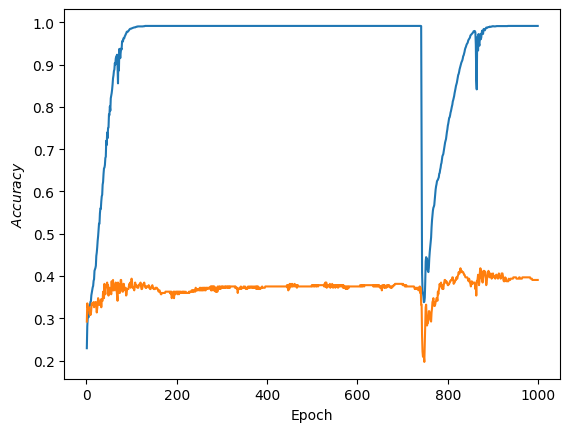

In [27]:
import seaborn as sns


history = pd.DataFrame(
    history, columns=['Epoch', 'Train Accuracy', 'Validation Accuracy'])


(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('Epoch')
ax.set_ylabel('$Accuracy$')
sns.lineplot(data=history, x='Epoch', y='Train Accuracy',ax=ax)
sns.lineplot(data=history, x='Epoch', y='Validation Accuracy' ,ax=ax)


plt.show()

Accuracy:	0.375
Precision:	0.355
Recall:  	0.363
F1 Score:	0.357



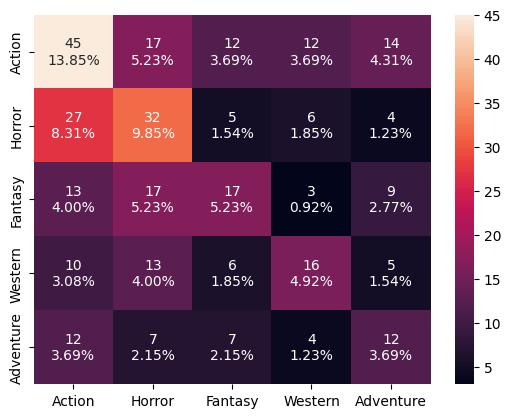

In [28]:
with torch.no_grad():
    outputs = torch.softmax(
        model(indexed_test_x, test_lens_x), dim=1).cpu().numpy().argmax(axis=1)

actual    = indexed_test_y.cpu()
prediction = outputs
    
cm = sklearn.metrics.confusion_matrix(actual, outputs)
count      = ["{0:0.0f}".format(v) for v in cm.flatten()]
percentage = ["{0:.2%}".format(v) for v in cm.flatten()/np.sum(cm)]
labels = np.asarray([f"{v1}\n{v2}" for v1, v2 in
          zip(count,percentage)]).reshape(5,5)

sns.heatmap(cm,fmt='',annot=labels,
            xticklabels=cat2idx.keys(),yticklabels=cat2idx.keys())

#Generate Accuracy, Precision, Recall, F1 Score   
print('Accuracy:\t%.3f'%  sklearn.metrics.accuracy_score (prediction, actual))
print('Precision:\t%.3f'% sklearn.metrics.precision_score(prediction, actual, average='macro'))
print('Recall:  \t%.3f'%  sklearn.metrics.recall_score   (prediction, actual, average='macro'))
print('F1 Score:\t%.3f'%  sklearn.metrics.f1_score       (prediction, actual, average='macro'))
print()

Measure the F1 score performance of the model when applied on the test set.
Also plot a confusion matrix showing how often each genre is mistaken as another genre.

## Title generation (25%)

Now that you've proven that titles and genre are related, make a model that can generate a title given a genre.

Again, you need to generate tokens at the character level instead of the word level and the titles must be lowercased.
Preprocess the data sets, create a neural network, and train it to generate the movie titles given their genre.
Plot a graph of the **perplexity** of the model on the train and validation sets after each epoch.

In [7]:
# Get all titles
titles = df['title']
genres = df['genre']

# Tokenise every character
titles = titles.apply(lambda s: [*s])

# Split into Train (80%), Validate (10%), Test (10%)

# Train = 80%, Other = 20%
train_titles, other_titles, train_genres, other_genres = \
    sklearn.model_selection.train_test_split(titles, genres,
                                             test_size=0.2, random_state=1)

# Split Other in half -> [Train = 80%, Val = 10%, Test = 10%]
val_titles, test_titles, val_genres, test_genres = \
    sklearn.model_selection.train_test_split(other_titles, other_genres,
                                             test_size=0.5, random_state=1)

# Get Encoding of genres
categories = ['Action', 'Horror', 'Fantasy', 'Western', 'Adventure']
cat2idx = {cat: i for (i, cat) in enumerate(categories)}

# Train Genres
train_genres = torch.tensor(train_genres.map(cat2idx.get).to_numpy()[
    :, None], dtype=torch.int64, device=device)
train_genres = torch.nn.functional.one_hot(
    train_genres[:, 0], num_classes=5).float()

# Test Genres
test_genres = torch.tensor(test_genres.map(cat2idx.get).to_numpy()[
    :, None], dtype=torch.int64, device=device)
test_genres = torch.nn.functional.one_hot(
    test_genres[:, 0], num_classes=5).float()


# Validate Genres
val_genres = torch.tensor(val_genres.map(cat2idx.get).to_numpy()[
    :, None], dtype=torch.int64, device=device)
val_genres = torch.nn.functional.one_hot(
    val_genres[:, 0], num_classes=5).float()


# Get length of every title including the EDGE token
train_title_lens = torch.tensor([len(t)+1 for t in train_titles],
                                dtype=torch.int64, device=device)
val_title_lens = torch.tensor([len(t)+1 for t in val_titles],
                              dtype=torch.int64, device=device)
test_title_lens = torch.tensor([len(t)+1 for t in test_titles],
                               dtype=torch.int64, device=device)

# Get maximum length of a title
train_max_len = max(train_title_lens)
val_max_len = max(val_title_lens)
test_max_len = max(test_title_lens)


# Create the vocabulary on the training set
# And Replace characters that appear less than 3 times with <UNK>
freq = collections.Counter(token for title in train_titles for token in title)
vocab = ['<PAD>', '<EDGE>'] + \
    sorted([token if freq[token] > 3 else '<UNK>' for token in freq.keys()])

# Return <UNK> index if the token is not in the vocabulary


def v_idx(t): return vocab.index(['<UNK>', t][t in vocab])



# Get train_x
padded_train_x = [['<EDGE>']+t+['<PAD>']
                  * (train_max_len-len(t)-1) for t in train_titles]
indexed_train_x = torch.tensor(
    [[v_idx(tok) for tok in t] for t in padded_train_x],
    dtype=torch.int64, device=device)

# Get train_y
padded_train_y = [t+['<EDGE>']+['<PAD>']
                  * (train_max_len-len(t) - 1) for t in train_titles]
indexed_train_y = torch.tensor(
    [[v_idx(tok) for tok in t] for t in padded_train_y],
    dtype=torch.int64, device=device)


# Get val_x
padded_val_x = [['<EDGE>']+t+['<PAD>']
                * (val_max_len-len(t)-1) for t in val_titles]
indexed_val_x = torch.tensor(
    [[v_idx(tok) for tok in t] for t in padded_val_x],
    dtype=torch.int64, device=device)

# Get val_y
padded_val_y = [t+['<EDGE>']+['<PAD>']
                * (val_max_len-len(t) - 1) for t in val_titles]
indexed_val_y = torch.tensor(
    [[v_idx(tok) for tok in t] for t in padded_val_y],
    dtype=torch.int64, device=device)


# Get test_x
padded_test_x = [['<EDGE>']+t+['<PAD>']
                 * (val_max_len-len(t)-1) for t in test_titles]
indexed_test_x = torch.tensor(
    [[v_idx(tok) for tok in t] for t in padded_test_x],
    dtype=torch.int64, device=device)

# Get test_y
padded_test_y = [t+['<EDGE>']+['<PAD>']
                 * (test_max_len-len(t) - 1) for t in test_titles]
indexed_test_y = torch.tensor(
    [[v_idx(tok) for tok in t] for t in padded_test_y],
    dtype=torch.int64, device=device)

In [8]:
class Model(torch.nn.Module):

    def __init__(self, cond_size, vocab_size, embedding_size, hidden_size):
        super().__init__()

        self.embedding_layer = torch.nn.Embedding(vocab_size, embedding_size)
        
        self.rnn_s0 = torch.nn.Parameter(
            torch.zeros((hidden_size,), dtype=torch.float32))
        self.rnn_c0 = torch.nn.Parameter(
            torch.zeros((hidden_size,), dtype=torch.float32))
        self.rnn_cell = torch.nn.LSTMCell(embedding_size, hidden_size)
        
        self.output_layer = torch.nn.Linear(cond_size+hidden_size, vocab_size)
        
        
    def forward(self, cond, x):
        batch_size = x.shape[0]
        time_steps = x.shape[1]
        
        embedded = self.embedding_layer(x)
        
        state = self.rnn_s0.unsqueeze(0).tile((batch_size,1))
        c = self.rnn_s0.unsqueeze(0).tile((batch_size,1)) #ERROR??
        interm_states = []
        
        #Get intermediate states
        for t in range(time_steps):
            (state,c) = self.rnn_cell(embedded[:,t,:], (state,c))
            interm_states.append(state)
        interm_states = torch.stack(interm_states, dim=1)
        
        #Replicate the same conditioning vector for every character
        cond_3d = cond.unsqueeze(1).tile((1, time_steps, 1))
        
        #Attach the replicated conditioning vector to the intermediate states
        interm_states = torch.cat((cond_3d, interm_states), dim=2)
        
        return self.output_layer(interm_states)  

In [22]:
model = Model(train_genres.shape[1], len(vocab),
              embedding_size=256, hidden_size=64)
model.to(device)

optimiser = torch.optim.AdamW(model.parameters())

print('step', 'error')
train_errors = []
batch_size = indexed_train_x.shape[0]
time_steps = indexed_train_x.shape[1]

mask = torch.zeros((batch_size, time_steps), dtype=torch.bool, device=device)
for i in range(batch_size):
    for j in range(time_steps):
        if j >= train_title_lens[i]:
            mask[i, j] = 1

perplexity = []

for step in range(1, 1_000+1):
    optimiser.zero_grad()
    output = model(train_genres, indexed_train_x)
    errors = torch.nn.functional.cross_entropy(
        output.transpose(1, 2), indexed_train_y, reduction='none')
    errors = torch.masked_fill(errors, mask, 0.0)
    error = errors.sum()/train_title_lens.sum()
    error.backward()
    optimiser.step()

    # Calculate Perplexity

    if step % 250 == 0:
        with torch.no_grad():

            # Train
            outputs = torch.log_softmax(output, dim=2)
            total_word_log_prob = 0.0
            num_words = 0

            for (sent, title_len, log_probs, y) in zip(titles, train_title_lens, outputs, indexed_train_y):
                word_log_probs = log_probs[torch.arange(
                    title_len), y[:title_len]]
                total_word_log_prob += word_log_probs.sum().tolist()
                num_words += title_len.tolist()

            pplx_train = np.exp(-1/num_words*total_word_log_prob)

            # Val
            outputs = torch.log_softmax(
                model(val_genres, indexed_val_x), dim=2)
            total_word_log_prob = 0.0
            num_words = 0

            for (sent, title_len, log_probs, y) in zip(titles, val_title_lens, outputs, indexed_val_y):
                word_log_probs = log_probs[torch.arange(
                    title_len), y[:title_len]]
                total_word_log_prob += word_log_probs.sum().tolist()
                num_words += title_len.tolist()

            pplx_val = np.exp(-1/num_words*total_word_log_prob)

            perplexity.append((step, pplx_train, pplx_val))

    print(step, end='\r')

    if step % 2_000 == 0:
        print(step, error.tolist(), end='\r')
print()

step error
1000


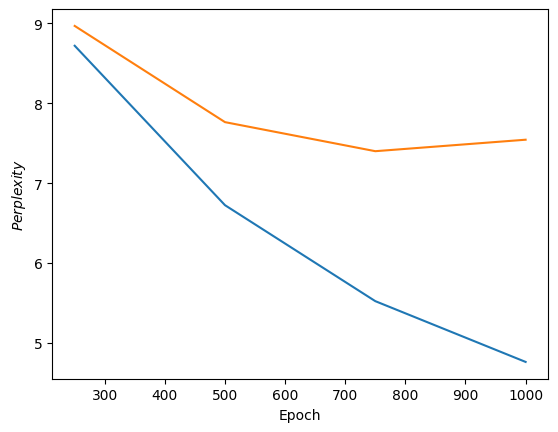

In [23]:
import seaborn as sns


history = pd.DataFrame(
    perplexity, columns=['Epoch', 'Train Perplexity', 'Validation Perplexity'])


(fig, ax) = plt.subplots(1, 1)
sns.lineplot(data=history, x='Epoch', y='Train Perplexity',ax=ax)
sns.lineplot(data=history, x='Epoch', y='Validation Perplexity' ,ax=ax)

ax.set_xlabel('Epoch')
ax.set_ylabel('$Perplexity$')

plt.show()

Generate 3 titles for every genre.
Make sure that the titles are not all the same.

In [37]:
name_genre = [('Action',   [0,0,0,0,0]),('Action',   [0,0,0,0,0]),('Action',   [0,0,0,0,0]),
              ('Horror',   [0,0,0,0,1]),('Horror',   [0,0,0,0,1]),('Horror',   [0,0,0,0,1]),
              ('Fantasy',  [0,0,0,1,0]),('Fantasy',  [0,0,0,1,0]),('Fantasy',  [0,0,0,1,0]),
              ('Western',  [0,0,1,0,0]),('Western',  [0,0,1,0,0]),('Western',  [0,0,1,0,0]),
              ('Adventure',[0,1,0,0,0]),('Adventure',[0,1,0,0,0]),('Adventure',[0,1,0,0,0]),
             ]
with torch.no_grad():
    for (i,(name, genre)) in enumerate(name_genre):
        
        genre = torch.tensor([genre], dtype=torch.float32, device=device)
        prefix_indexes = [vocab.index('<EDGE>')]
        
        if i!=0 and i%3==0:print('\n')
            
        #Start generating words
        max_characters = 20
        for _ in range(max_characters):
            
            prefix_tensor = torch.tensor(
                [prefix_indexes], dtype=torch.int64, device=device)
            
            outputs = torch.softmax(model(genre, prefix_tensor), dim=2)
            
            char_probs = outputs[0, -1, :].cpu().numpy()
            
            #Set <UNK> probability to 0
            char_probs[v_idx('<UNK>')] = 0
            
            #Get next character
            next_char_index = random.choices(range(len(vocab)), char_probs)[0]
            
            #Stop when <EDGE> token is encountered
            if next_char_index == vocab.index('<EDGE>'):
                break
            
            prefix_indexes.append(next_char_index)
            
            
        sent = [vocab[index] for index in prefix_indexes[1:]]
        print(f"{name}: {''.join(sent)}")

Action: strankete
Action: the pestopt
Action: greeg deyland


Horror: the poirray
Horror: evil cataled
Horror: pagored


Fantasy: furraw
Fantasy: the burkers battes
Fantasy: the crarion nacker


Western: phaneto daye
Western: the threted man
Western: twerrogann tworsters


Adventure: walken wondse
Adventure: storilath
Adventure: reth whip pery


## Language models as classifiers (30%)

It occurs to you that the movie title generator can also be used as a classifier by doing the following:

* Let title $t$ be the title that you want to classify.
* For every genre $g$,
    * Use the generator as a language model to get the probability of $t$ (the whole title) using genre $g$.
* Pick the genre that makes the language model give the largest probability.

The producer is thrilled to not need two separate models and now you have to implement this.
**Use the preprocessed test set from the previous task** in order to find the genre that makes the language model give the largest probability.
There is no need to plot anything here.

In [38]:
name_genre = [('Action',   torch.tensor([[0,0,0,0,0]]*(len(indexed_test_x)), dtype=torch.float32, device=device)),
              ('Horror',   torch.tensor([[0,0,0,0,1]]*(len(indexed_test_x)), dtype=torch.float32, device=device)),
              ('Fantasy',  torch.tensor([[0,0,0,1,0]]*(len(indexed_test_x)), dtype=torch.float32, device=device)),
              ('Western',  torch.tensor([[0,0,1,0,0]]*(len(indexed_test_x)), dtype=torch.float32, device=device)),
              ('Adventure',torch.tensor([[0,1,0,0,0]]*(len(indexed_test_x)), dtype=torch.float32, device=device))]

genre_probs = []

#For every genre
for name,genre in name_genre:
    with torch.no_grad():
        
        #Get log probability of next character given every..
        #..prefix of every title given the genre
        outputs = torch.log_softmax(model(genre,indexed_test_x),
                                    dim=2)
        
        title_probs = []
        
        #Get probability of whole sentence by summing up log probabilities 
        for (title_len, log_probs, y) in zip(test_title_lens, outputs, indexed_train_y):
            char_log_probs = log_probs[torch.arange(title_len), y[:title_len]]
            title_probs.append(torch.exp(char_log_probs.sum()))
        
        #Append probability of every title for this genre
        genre_probs.append(title_probs)

#Get most probable genre for every title
genre_probs = torch.tensor(genre_probs, dtype=torch.float32, device=device).transpose(1,0)
prediction = torch.argmax(genre_probs, axis=1).tolist()

Just like in the classification task, measure the F1 score and plot the confusion matrix of this new classifier.

Accuracy:	0.218
Precision:	0.200
Recall:  	0.210
F1 Score:	0.198



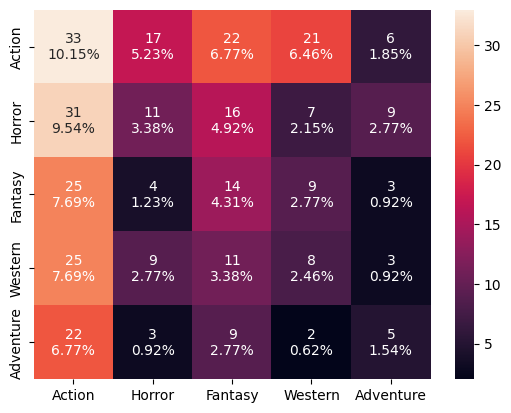

In [39]:
actual     = torch.argmax(test_genres.cpu(), dim=1).tolist()
    
cm = sklearn.metrics.confusion_matrix(actual, prediction)
count      = ["{0:0.0f}".format(v) for v in cm.flatten()]
percentage = ["{0:.2%}".format(v) for v in cm.flatten()/np.sum(cm)]
labels = np.asarray([f"{v1}\n{v2}" for v1, v2 in
          zip(count,percentage)]).reshape(5,5)

sns.heatmap(cm,fmt='',annot=labels,
            xticklabels=cat2idx.keys(),yticklabels=cat2idx.keys())

#Generate Accuracy, Precision, Recall, F1 Score   
print('Accuracy:\t%.3f'%  sklearn.metrics.accuracy_score (prediction, actual))
print('Precision:\t%.3f'% sklearn.metrics.precision_score(prediction, actual, average='macro'))
print('Recall:  \t%.3f'%  sklearn.metrics.recall_score   (prediction, actual, average='macro'))
print('F1 Score:\t%.3f'%  sklearn.metrics.f1_score       (prediction, actual, average='macro'))
print()

Write a paragraph or psuedo code to describe what your code above does.

In [75]:
'''
genre_probabilities = []

For every genre g
    title_probs = []
    
    Get the log probabilities of the next character given every
    prefix of every title given g
    
    title_probs = Get the probability of every title by summing up the individual log
    probabilities of the actual next character given the prefix, and then exponentiating it.
      
    genre_probabilities.append(title_probs)
    
transpose genre_probabilities in order to get the different genre probability
for every title

choose the highest probability outof the 5 genres for every title,
and let that be the predicted genre

    

'''

'\nFor every title t\n\n    genre_scores = []\n    \n    For every genre g\n        score = 0\n        \n        For every character c of t\n            score += probability that the next character of the prefix t[:c] was t[c+1]\n        \n        score /= len(t) #Normalise over length of title\n        \n        genre_scores.append(score)\n    \n    \n    "Which genre had the highest score?"\n    predicted_genre.append(argmax(genre_scores))            \n\n'

## Conclusion (10%)

The producer's funders are asking for a report about this new technology they invested in.
In 300 words, write your interpretation of the results together with what you think could make the model perform better.

In [ ]:
'''

'''